## 準備
  
教科書では計算は主にエクセルによる関数で実行されています。エクセルはGUI上の操作性は抜群なのですが、外部のWebシステムと連携するためのAPIのライブラリやデータ分析ツールとの連携が十分でないため、本サイトではpythonにより教科書と同じ計算を行います。そのための準備です。

### github
- githubのjupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/article/mkt/1/1_nb.md)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/article/mkt/1/1_nb.ipynb)

### 筆者の環境
筆者の環境です。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G95


In [2]:
!python -V

Python 3.5.5 :: Anaconda, Inc.


必要なライブラリを読み込みます。

In [3]:
import numpy as np
import scipy
from scipy.stats import binom

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print("numpy version :", np.__version__)
print("matplotlib version :", matplotlib.__version__)
print("sns version :",sns.__version__)

numpy version : 1.18.1
matplotlib version : 2.2.2
sns version : 0.8.1


## 概要
限られた時間の中で生きている我々が知ることが出来るのは、平均値とその分散（標準偏差）のみです。マーケティングの世界で例えると、一日あたりの来店者数、一日あたりの商品の売り上げ数などです。では、その限られた情報から何を知ることが出来るでしょうか？今日の来店者数が１０００人だった場合、明日の来店者数が５００の確率はどのぐらいでしょうか？また、１５００人である確率はどのぐらいでしょうか？その答えを教えてくれるのが確率分布になります。

「確率思考の戦略論」では、確率分布の形状を決める平均値と標準偏差に相当する数字を $M$と$K$という二つのパラメタで表現できるとしています。$M$が消費者のプリファレンス（相対的好意度）そのものであり、$K$は$M$の関数です。本書では一貫して以下の事を主張しています。

プリファレンス（相対的好意度）がブランドのマーケット・シェア、浸透率、購入回数を支配している
理由は以下の3点です（教科書の写し書きです）。

1. プリファレンスは消費者の頭の中にあり、人の購買行動を支配している。直接的な証拠は、消費者のプリファレンスに基づく「BP-10シェアモデル」が現実のシェアを比較的高い精度で予測できる事である。<font color="MediumVioletRed">消費者のプリファレンスがシェアを支配し、売り上げを支配している。</font>言い換えれば、100%の認知、100%の配下率、十分な時間があればプリファレンスとユニット・シェアは同じものになる。プレファレンスは消費者の頭の中にあり、それが現実に現れたのがユニット・シェアである。
2. 負の二項分布モデルにより、カテゴリーおよびブランドの浸透率と回数別分布は、MとKの二つのパラメタのみで現実に非常に近い正確な予測が出来る。$M$も$K$もプリファレンスの関数である。
3. カテゴリーのMとK、ユニット・シェア、デリシュレーSをインプットとして、デリシュレーNBDモデルは各ブランドの現実に非常に近い浸透率と回数別購入率の分布を正確に予測する事が出来る。ブランド間のスイッチングも正確に予測できる。デリシュレー$S$も$K$もプリファレンスの関数である。

本サイトでは、「確率思考の戦略論」にそって

1. 二項分布 
2. ポアソン分布 
3. 負の二項分布 
4. ポアソン分布と負の二項分布のまとめ 
5. 売り上げを支配する重要な式 
6. デリシュレーNBDモデル

の順に沿って解説を行います。

## 1-1. 二項分布 (Binomicl Distribution)

### 1. 二項分布の式
二項分布は成功確率$\displaystyle p$の試行を $\displaystyle N$回行い、その成功回数$r$を確率変数とする確率分布の事です。一般的には以下の様な確率質量関数として定義されています。正規分布などの説明に用いられる確率密度関数ではなく、確率質量関数となっているのは$r$が正の整数しか取らない離散値だからです。

$$ \frac{N!}{r! \(N-r\)!} \times p^r \times \left(1-p\right)^{N-r}  \cdot \cdot \cdot \cdot  \left(1\right) $$

本章では、二項分布をくじ引きを例に説明しています。くじが全部で$n$個あり、その中の$\theta$個が当たりとします。そうすると、一回目のくじ引きであたりのくじを引く確率は$\displaystyle \frac{\theta}{n}$となります。はずれのくじを引く確率は$\displaystyle 1-\frac{\theta}{n}$ となります。あたりのくじを引く回数が$r$回、はずれのくじを引く回数は$\displaystyle N-r$回なので、例えば、最初の$r$回連続であたりのくじを引き、その後、$1-r$回連続ではずれのくじを引く確率は、

$$ \left(\frac{\theta}{n}\right)^r \times \left(\frac{n-\theta}{n}\right)^{N-r}  \cdot \cdot \cdot \cdot  \left(2\right) $$

となります。後は、その組み合わせを考える必要があります。その組み合わせは高校数学で習ったとおり、$N$中、$r$回のあたりを引く確率なので、$\displaystyle {}_n \mathrm{C}_r =  \frac{N!}{r! \(N-r\)!} $となり、

$$ \frac{N!}{r! \(N-r\)!} \times \left(\frac{\theta}{n}\right)^r \times \left(\frac{n-\theta}{n}\right)^{N-r}  \cdot \cdot \cdot \cdot  \left(3\right) $$
となります。

### 2. pythonによる計算例

平均    :  30.0
標準偏差 : 21.0


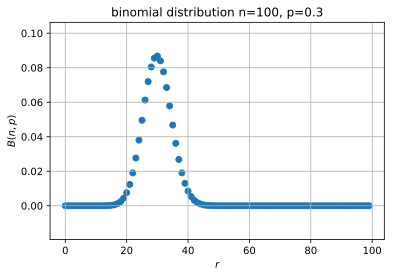

In [4]:
x = np.arange(100)

n = 100
p = 0.3
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')
print("平均    : ", mean)
print("標準偏差 :", var)

plt.xlabel('$r$')
plt.xlabel('$r$')
plt.ylabel('$B(n,p)$')
plt.title('binomial distribution n={}, p={}'.format(n,p))
plt.grid(True)

y = binom.pmf(x,n,p)
plt.scatter(x,y)
# sns.plot(x=x, y=y)  
# sns.scatterplot(data=tips, x='total_bill', y='tip')

plt.show()

## 1-2. ポアソン分布 (Poisson Distribution)

### 1. ポアソン分布の意味
ポアソン分布は単位期間あたり$\mu$回起こる<font color="MediumVioletRed">ランダムな事象</font>の発生回数が従う分布になります。ポアソン分布が持つパラメタこの$\mu$一つだけです。数式で表すと、

$$P\left(r|\mu \right) = \frac{\mu^r}{r!}e^{-\mu}$$

となります。本書に習って$\mu = 0.6$の場合に$r=0,1,2,3,4$の各場合について計算した結果が以下の通りです。

<style>.cent td {text-align:center;}</style>
<style>.cent tr {text-align:center;}</style>

<div style="width:100%;"> 
<table class="cent">
  <tr>
    <th>$r$</th>
    <th>0</th>
    <th>1</th>
    <th>2</th>
    <th>3</th>
    <th>4</th>
  </tr>
  <tr>
    <td>確率</td>
    <td>54.88%</td>
    <td>32.92%</td>
    <td>9.88%</td>
    <td>1.98%</td>
    <td>0.30%</td>
  </tr>
</table>
</div>

グラフと計算に利用したpythonのコードを以下に示します。

平均    :  0.6
標準偏差 : 0.6


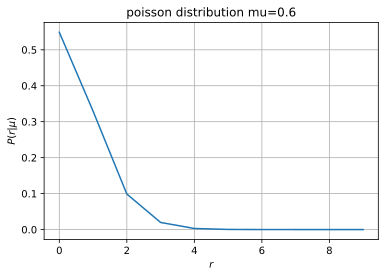

In [5]:
from scipy.stats import poisson

x = np.arange(10)

mu = 0.6
mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')
print("平均    : ", mean)
print("標準偏差 :", var)

y = poisson.pmf(x,mu)

plt.xlabel('$r$')
plt.ylabel('$P(r|\mu)$')
plt.title('poisson distribution mu=%.1f' % (mu))
plt.grid(True)

plt.plot(x,y)

plt.show()

## 1-3. 負の二項分布 (Negative Binomical Distribution)

この章では、最初に重要な結論が書かれています。

```text
個人個人の購買行動はポアソン分布をしているが、消費者全体を見ると「負の二項分布」をしている
```

なぜ、消費者全体を見ると負の二項分布をしているかが書かれておらず、以後、負の二項分布を仮定して議論が進みます。しかし、先の章の話になってしまいますが、1-4.の「ポアソン分布」と「負の二項分布」のまとめのP254の下の方に、

- あ）個人レベルでポアソン分布している
- い）長期平均値 $\mu $は消費者全体で見たときガンマ分布している

と書かれており、さらに、

- この二つの前提が成り立つとき、消費者全体で見たときにある期間の実際の購入確率は負の二項分布すると覚えてください

と書かれています。つまり、消費者全体で見たときに負の二項分布をすると言うのは、（あ）と（い）の結果でしかないのです。


その結果として、消費者全体によってあるカテゴリー、もしくは、あるブランドが選ばれる確率は

$$ P\left(r \right) = \frac{\left(1 + \frac{M}{K} \right)^{-K} \cdot \Gamma\left(K + r \right)}{\Gamma\left(r + 1 \right)\cdot \Gamma\left(K \right)} \cdot \left(\frac{M}{M+K} \right)^r \cdots \left(1 \right)$$

と計算できると述べています。その後に、その負の二項分布が、「成功が成功を呼ぶ分布」としてのガンマ分布を仮定することによって$\left(1 \right)$が導かれる事が証明されていますが、この理解は後で良いかと思います。繰り返しますが、重要なのは、

```text
ポアソン分布とガンマ分布を仮定することによって、負の二項分布が導かれる
```

という事です。

※実際に個人レベルのポアソン分布と消費者全体でのガンマ分布を仮定することによって負の二項分布が導かれることは1.6で証明します。

## 1-4. ポアソン分布と二項分布のまとめ

1.4 では「ポアソン分布と二項分布のまとめ」と主題でまとめていますが、重要な点は繰り返しになりますが以下の通りです。

- 消費者があるカテゴリーを選ぶ場合もあるブランドを選ぶ場合もその仕組みは同じである。すなわち、消費者がどのカテゴリーを選ぶかという問題と、どのブランドを選ぶかという問題は同じ確率分布を用いて解く事が出来る。
- 消費者個人の購買の分布は「ポアソン分布」している。
- 上記2点の結果として、ある期間における消費者全体の購入回数の分布は「負の二項分布」に従う 

※ここで述べていることは、教科書と原因と結果の因果関係が異なります。教科書では、ポアソン分布と負の二項分布の結果からガンマ分布を導かれると書かれていますが、同じページの下の部分では、ポアソン分布とガンマ分布から負の二項分布が導かれると書かれているので、ここではそちらの理解の立場を取ります。

### ガンマ関数の表記
一般的にガンマ分布を表す数式は、形状を決定するパラメタ $\alpha, \beta$を用いて、

$$ f\left(x|\alpha, \beta \right) =\frac{\beta^{\alpha}x^{\alpha - 1}e^{-\beta x}}{\Gamma\left(\alpha \right)} \cdot\cdot\cdot\cdot\left(1\right) $$

と表現されます。また、$\displaystyle \beta =\frac{1}{\theta} $として、

$$ f\left(x|\alpha, \theta \right) =\frac{x^{\alpha - 1}e^{-\frac{x}{\theta}}}{\Gamma\left(\alpha \right)\theta^{\alpha}} \cdot\cdot\cdot\cdot\left(2\right) $$

<a href="https://en.wikipedia.org/wiki/Gamma_distribution" target="_blank">wikipedia</a>でもこの二通りの数式で表記されています。ここで、(1)と(2)における確率分布の平均と標準偏差は以下の通りです。

<style>.cent td {text-align:center;}</style>
<style>.cent tr {text-align:center;}</style>

<div style="width:100%;"> 
<table>
  <tr>
    <th>ガンマ分布</th>
    <th>$\displaystyle E[x]$</th>
    <th>$\displaystyle V[x]$</th>
  </tr>
  <tr>
    <td>$ \displaystyle \frac{\beta^{\alpha}x^{\alpha - 1}e^{-\beta x}}{\Gamma\left(\alpha \right)} $</td>
    <td>$\displaystyle \frac{\alpha}{\beta}$</td>
    <td>$\displaystyle \frac{\alpha}{\beta^2}$</td>
  </tr>
  <tr>
    <td>$\displaystyle \frac{x^{\alpha - 1}e^{-\frac{x}{\theta}}}{\Gamma\left(\alpha \right)\theta^{\alpha}} $</td>
    <td>$\displaystyle \alpha\theta$</td>
    <td>$\displaystyle \alpha\theta^2$</td>
  </tr>
</table>
</div>

本書では、$\displaystyle Gamma \left(K,\frac{M}{K} \right)$がどちらの表記を用いているか明示されていませんが、$\displaystyle Gamma \left(1,5 \right)$、$\displaystyle Gamma \left(3,\frac{5}{3} \right)$、$\displaystyle Gamma \left(15,\frac{5}{15} \right)$の平均値はすべて5と述べているので、(2)の表記を用いていると思われます。

### python code
ガンマ分布を記述するpythonのコードです。moduleとしてscipy、numpy、matplotlibなど機械学習ではおなじみのライブラリを用いてます。

### ガンマ分布のpython code
上記のコードの実行結果です。

- $\displaystyle \left(K,\frac{M}{K} \right) = \left(1,5 \right) , \left(3,\frac{5}{3} \right), \left(15,\frac{5}{15} \right) $の三通りについてプロットしています。教科書のP61の図2-2と同じようなグラフが得られています


a : 1.0, b : 5.000, mean : 5.0
a : 3.0, b : 1.667, mean : 5.0
a : 15.0, b : 0.333, mean : 5.0


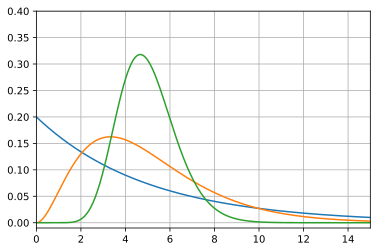

In [6]:
from scipy.stats import gamma

x = np.linspace(0,50,1000)

a = 1.0 
b = 5.0
mean, var, skew, kurt = gamma.stats(a, scale=b, moments='mvsk')
y1 = gamma.pdf(x, a, scale=b)
print('a : {}, b : {:,.3f}, mean : {}'.format(a,b,mean))

a = 3.0
b = 5.0/3.0
mean, var, skew, kurt = gamma.stats(a, scale=b, moments='mvsk')
print('a : {}, b : {:,.3f}, mean : {}'.format(a,b,mean))
y2 = gamma.pdf(x, a, scale=b)

a = 15.0
b = 1.0/3.0
mean, var, skew, kurt = gamma.stats(a, scale=b, moments='mvsk')
print('a : {}, b : {:,.3f}, mean : {}'.format(a,b,mean))
y3 = gamma.pdf(x, a, scale=b)

plt.grid()
plt.ylim([-0.01,0.40])
plt.xlim([0,15])

plt.plot(x, y1, x, y2, x, y3)

plt.show()

## 1-5. 売り上げを支配する重要な式

この章で重要なのは、表９−５であり、消費者全体がどの「カテゴリー」、もしくは、「ブランド」を選ぶかは負の二項分布に従い、それぞれの平均購入回数$M$や、分布を決定するパラメタ$K$がどのように決定されるか示されています。「カテゴリー」を表現した式も、「ブランド」を表現した式もほぼ同じような数式で表現されています。違うのは添字ぐらいでしょうか。

本書を理解する上で重要だと思われる点はパラメタ$K$の説明がされているP258の中段の説明になります。

- パラメタ$\left(k_j \right) $は、最初にあった赤玉の$\displaystyle \left(\theta_j \right) $を1回ずつ袋に足す玉の数$\displaystyle\left(d_i \right) $割った値で$\theta_j$ の関数です。分散の式が示すように、赤玉が多くなる（プリファレンスが増える）事により分散が大きくなり、浸透率$\theta$に対しての微分が示すように、より多くの人に広がります。市場の構造上のプリファレンスが高くなれば、より人々に広がります。

　すなわち、$K$というのは、プリファレンスの関数であり、プリファレンスが増加するごとに、増加するする値である事が説明されています。

　負の二項分布は、

$$
P\left(r \right) = \frac{\left(1 + \frac{M}{K} \right)^{-K} \cdot \Gamma\left(K + r \right)}{\Gamma\left(r + 1 \right)\cdot \Gamma\left(K \right)} \cdot \left(\frac{M}{M+K} \right)^r \cdots \left(1 \right)
$$

と表され、$M$はプリファレンスであり、$K$がプリファレンスの関数であれば、$P\left(r \right)$は$M$のみをパラメタに持つ関数という事になります。これは本書で筆者たちがいい関して主張している結論になります。

## 1-6. デリシュレーNBDモデル

### デリシュレーNBDモデルとは
デリシュレーNBDモデルとは、あるカテゴリーの中のブランド間の関係を教えてくれる確率分布になります。この分布を用いてわかる具体例として本書で上げられているのが、P31の表1-4になります。与えら得た式(後述の式１)に対して、どのようにパラメタを計算しているのかが具体的に示されています。

本章の内容はかなり高度なレベルとなっています。少しずつ読み解いてみます。

### 勝手な注釈
私ごときが注釈をつけるのは失礼に当たるのですが、私と同じレベルの読者が少々戸惑う場面もあると思いますので、少し追記しておきます。

#### デリシュレーについて
著者は「Dirichlet」をデリシュレーと表記していますが、おそらく一般的にはディリクレと表記される場合が多いかと思います。統計の分野でもディリクレ分布、数値計算の分野でも境界値問題でディリクレ問題などと言いますので、混同しないように気をつけた方が良いかと思います。私も普段はディリクレと言いますが、以下ではデリシュレーに統一します。

#### ガンマ分布からデリシュレー分布の導出について
ヤコビアンの計算などが重なり、計算が複雑になっているように思えます。最初から、ブランドが選択される

もしかしたらマーケティング系の論文では教科書のような導出が定石となっていたりした場合は私の知識不足となります。

以下では、本書に従い、ブランドの購入回数が、ガンマ分布よりサンプリングされ、それを変数変換によりデリシュレー分布を導出する部分の数式の説明もしようと思います。

### 概要

まず結論からです。デリシュレーNBDは以下の様な数式で表せると結論づけています。

<div>
$$
\begin{aligned}
P_{r} \left(R,r_1, r_2, \cdots , r_g \right) &=\frac{\Gamma\left(S \right)}{\displaystyle \prod_{i=1}^{N} \Gamma\left(\alpha_j \right)} \cdot \frac{\displaystyle \prod_{i=1}^{N} \Gamma\left(r_j + \alpha_j \right)}{\Gamma\left(S+R \right)} \cdot \frac{1}{\displaystyle \prod_{j=1}^{g} r_j!} \cdot \\ 
&\qquad \frac{\Gamma\left(R + K \right)}{\displaystyle \Gamma\left(K \right)} \cdot \left(1 + \frac{K}{MT} \right)^{-R} \cdot\left(1 + \frac{MT}{K} \right)^{-K} \cdot\cdot\cdot\cdot\left(1\right) \\ 
\\
R&=\sum_{j=i}^{g}r_j  \cdot\cdot\cdot\cdot\left(2\right) 
\\
\\
\alpha_j &=S \times\left(ブランドjの購入頻度に基づくマーケットシェア \right)\cdot\cdot\cdot\cdot\left(3\right)  \\
\\
S &=\sum_{j=1}^g \alpha_j \cdot\cdot\cdot\cdot\left(4\right) 
\end{aligned}
$$
</div>

そして、数式が成り立つ前提は以下の様になっています。

1. 消費者各自の購買行動は独立事象
2. 購入行動はランダムに発生
3. 購入者各自$\left(C_i \right)$は、一定のカテゴリーに対して、長期的購入回数の平均値$\mu_i$を持つ。購入者各自$\left(C_i \right)$の単位時間のカテゴリ購入回数$R_i$はポアソン分布している。
$$R_i \sim Poisson\left(\mu_i \right)$$
4. カテゴリーの長期平均購入回数$\left(\mu \right)$は消費者間で異なり、ガンマ分布している。
$$\mu \sim Gamma\left(K,\frac{M}{K} \right)$$
5. 期間$T$における各ブランドの購入回数$\left(r_j \right)$は、ガンマ分布$Gamma\left(\alpha_j,\beta \right)$に従う。$\alpha$はブランド間で異なるが、$\beta$はブランド間で同一。
6. 各消費者は、各ブランドに対して一定の購買確率を持っており、ブランドの購入$\left(r \right)$ は多項分布に従う。各々のカテゴリーの購入時のブランドの購入確率$\left(p \right)$は、それぞれのブランドについて長期的に見ると決まっている。ただ、カテゴリー購入時にどれを選ぶかはランダムである。
7. 異なる人々の各々のカテゴリー平均購入回数と、人々のそれぞれのブランドを選択する確率とは、互いに独立。すなわち、特定のカテゴリー購入回数の人が、特定のブランドを特定の確率で購入しているような事が起こらない。

### パート1
ポアソン分布とガンマ分布の混合分布から負の二項分布を導きます。

<div>
$$
\begin{aligned}
P\left(r \right) &=\int_0^{\infty} Po\left(r|\lambda \right) Ga\left(\lambda | \alpha, \theta \right)  d\lambda    \\
&= \int_0^{\infty} \frac{\lambda^r e^{-\lambda}}{r!}\cdot \frac{\lambda^{\alpha - 1}e^{-\frac{\lambda}{\theta}}}{\Gamma\left(\alpha \right)\theta^\alpha } d\lambda \\
&= \frac{1}{r!\Gamma\left(\alpha \right)\theta^\alpha}  \int_0^{\infty} \lambda^{r+\alpha-1}e^{-\lambda\left(1 +\frac{1}{\theta}  \right)} d\lambda 
\end{aligned}
$$
</div>

ここで、ガンマ関数が、
$$
\Gamma\left(r \right) = \int_0^{\infty}t^{r-1}e^{-t}dt
$$

と定義できる事を念頭に、
$$
\lambda \left(1 +\frac{1}{\theta}  \right)  = t \rightarrow \lambda =  \frac{\theta t}{1 + \theta } 
$$

と変数変換すると、

<div>
$$
\begin{aligned}
P\left(r \right) &= \frac{1}{r!\Gamma\left(\alpha \right)\theta^\alpha}  \int_0^{\infty} \lambda^{r+\alpha-1}e^{-\lambda\left(1 +\frac{1}{\theta}  \right)} d\lambda \\
&=\frac{1}{r!\Gamma\left(\alpha \right)\theta^\alpha}  \int_0^{\infty}\left(\frac{\theta t}{1 + \theta} \right)^{r+\alpha -1}e^{-t}\frac{\theta}{1 + \theta}dt \\ 
&=\frac{1}{r!\Gamma\left(\alpha \right)\theta^\alpha} \left(\frac{\theta}{1 + \theta} \right)^{r+\alpha}\int_0^{\infty}t^{r+\alpha-1}e^{-t}dt \\
&= \frac{1}{r!\Gamma\left(\alpha \right)\theta^\alpha} \left(\frac{\theta}{1 + \theta} \right)^{r+\alpha}\Gamma\left(r + \alpha \right) 
\end{aligned}
$$
</div>

となります。また、$r! = \Gamma\left(r +1  \right) $に注意すると、

<div>
$$
\begin{aligned}
P\left(r \right) &= \frac{\Gamma\left(r+\alpha \right)}{\Gamma\left(\alpha \right)\Gamma\left(r + 1 \right)\theta^\alpha} \left(\frac{\theta}{1 + \theta} \right)^{r+\alpha} \\
&= \frac{\Gamma\left(r+\alpha \right)}{\Gamma\left(\alpha \right)\Gamma\left(r + 1 \right)} \left(\frac{\theta}{1 + \theta} \right)^{r} \left(1 + \theta \right)^{-\alpha} \\
&= \frac{\left(1 + \theta \right)^{-\alpha} \cdot \Gamma\left(r+\alpha \right)}{\Gamma\left(\alpha \right)\Gamma\left(r + 1 \right)} \left(\frac{\theta}{1 + \theta} \right)^{r} 
\end{aligned}
$$
</div>

と変形できます。ここで、$\alpha = K$、$\theta = \frac{M}{K} $を代入すると、

$$ P\left(r \right) = \frac{\left(1 + \frac{M}{K} \right)^{-K} \cdot \Gamma\left(K + r \right)}{\Gamma\left(r + 1 \right)\cdot \Gamma\left(K \right)} \cdot \left(\frac{M}{M+K} \right)^r $$

となり、1-3の負の二項分布の章で示した以下の式と一致します。以上から、

<div class="box1">
消費者個人の購買活動がポアソン分布しており、その長期平均購入回数がガンマ分布していることを仮定することによって、ある期間における消費者全体の購入回数は負の二項分布している
</div>

という事が導けました。

### パート2
#### 定義

test

<div>
$
\quad j(ブランド) : \{j \in N: 1 \leqq j \leqq g\} 
$
<div>

関数$G$は$r$の関数なので、これを確率$p$の関数に変換します。

ここで気をつけるのは、確率分布に関する変数変換は、単純に変数を入れ替える以外に、ヤコビアンという量が必要になります。それが教科書にある$|J|$です。

例えば、$p(x,y)$を変数$x,y$を確率変数とする連続確率分布を表すとします。普段はあまり意識することはないですが、連続確率分布はその値だけでは実は意味をなしません。例えば、$\displaystyle p(2,3)=\frac{1}{3}$という結果は、


正確な数学的な表現はルベーグ積分や知識が必要となりますが、マーケティングの世界では不要かと思います。ただ、このように数式をしっかり追うときに知識として必要になります。

ただし、離散型の確率分布の場合は異なるので注意が必要です。

これは実務レベルになると実感します。現実的なレベルでコンピュータに積分を計算施用とするとき、この$dxdy$を考慮しないと訳のわからない数値になり、モデルが意味をなさなくなるというのは、数値計算をしていれば誰も経験する事だと思います。


よく利用されるガウス積分を例にヤコビアンの計算をしてみます。$x=r\cos \theta, y=r\sin \theta$という極座標への変数変換を例に取ります。


<div>
$$
dxdy = |J|drd\theta
$$
</div>

なので、

<div>
$$
\mathrm{det}J = |J| = \left|
  \begin{array}{cc}
    \displaystyle \frac{\partial x}{\partial r} & \displaystyle \frac{\partial x}{\partial \theta} \\
    \displaystyle \frac{\partial y}{\partial r} & \displaystyle \frac{\partial y}{\partial \theta}
  \end{array}
\right| = \left| 
  \begin{array}{cc}
    \cos \theta & -r\sin \theta\\
    \sin \theta & r\cos \theta\\
  \end{array}
\right| = r
$$
</div>


<div>
$$
p(x,y)dxdy = p(r,\theta)rdrd\theta
$$
</div>


<div>
$$
\int_{-\infty}^{\infty}dx\int_{-\infty}^{\infty}dye^{-(x^2+y^2)} = \int_0^{\infty}dr\int_0^{2\pi}d\theta re^{-r^2} = \pi
$$
</div>

これより、

<div>
$$
\int_{-\infty}^{\infty}e^{-x^2}dx = \sqrt{\pi} 
$$
</div>

となり、ガウス積分の有名な公式が導けます。この辺の説明がないので、数学や確率・統計の知識があまりないと完全に理解するのは厳しいかもしれません。

#### test

<div>
$$
G(r_1,r_2,\cdots ,r_g) = \prod_{j=1}^{g} \frac{r_j^{\alpha_{j-1}}e^{-\frac{r_j}{\beta}}}{\Gamma(\alpha_j)\beta^{\alpha_j}}
$$
</div>


<div>
$$
D=\{(r_1,r_2,\dots, r_j \cdots,  r_g): 0 \leqq r_j < \infty , j = 1,2,\cdots j \cdots g \}
$$
</div>

<div>
$$
F=\{(p_1,p_2,\dots,p_j, \cdots,  p_g): 0 \leqq p_j < 1 , j = 1,2,\cdots j \cdots g \}
$$
</div>

$0 < p_g < \infty$となっていますが、おそらく誤植だと思います。


<div>
$$
$$
</div>

<div>
$$
$$
</div>

<div>
$$
$$
</div>

<div>
$$
$$
</div>


<div>
$$
|J| = \left|
  \begin{array}{cccc}
    \displaystyle \frac{\partial r_1}{\partial p_1} & \displaystyle \frac{\partial r_1}{\partial p_2} & \cdots & \displaystyle \frac{\partial r_1}{\partial p_{g'}} \\
    \displaystyle \frac{\partial r_2}{\partial p_1} & \displaystyle \frac{\partial r_2}{\partial p_2} & \cdots & \displaystyle \frac{\partial r_2}{\partial p_{g'}} \\
    \vdots & \vdots    & \ddots & \vdots \\
  \displaystyle \frac{\partial r_g}{\partial p_1} & \displaystyle \frac{\partial r_g}{\partial p_2} & \cdots & \displaystyle \frac{\partial r_g}{\partial p_{g'}} 
  \end{array}
\right|
$$
</div>

=======

<div>
$$
\left|
  \begin{array}{cccc}
    p_{g'} & 0 & \cdots & p_1 \\
    0 & p_{g'} & \cdots & p_2 \\
    \vdots & \vdots & \ddots & \vdots \\
    -p_{g'} & -p_{g'} & \cdots & \displaystyle 1- \sum_{j=1}^{g-1}\
  \end{array}
\right|
$$
</div>


行列式の特徴として、ある行にある行を足しても変わらないという特性があります。

２次の正方行列の場合の具体的な計算をしてみます。

<br>

式で書くと以下の通りです。


<div>
$$
\left|
  \begin{array}{cc}
    a & b \\
    c & d
  \end{array}
\right| = ad-bc
$$
</div>


<div>
$$
\left|
  \begin{array}{cc}
    a & b \\
    c + a & d + b
  \end{array}
\right| = a(d + b) - b(c + a) = ad - bc +ab -ab = ad -bc
$$
</div>

となり、

<div>
$$
\left|
  \begin{array}{cc}
    a & b \\
    c & d
  \end{array}
\right| = \left|
  \begin{array}{cc}
    a & b \\
    c + a & d + b
  \end{array}
\right|
$$
</div>

となることが分かります。3次以上の場合も同様に計算できます。

<br>

P267の下から2行目の「行を足しても変わらない」といっているのは、

- 1行目をg行目に加える <br>
- 2行目をg行目に加える <br>
- $\cdots$
- g-1行目をg行目に加える <br>

というように、g行目にそれ以外の行の値をすべて加えることを示しています。

<div>
$$
\left|
  \begin{array}{cccc}
    p_{g'} & 0 & \cdots & p_1 \\
    0 & p_{g'} & \cdots & p_2 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & 1
  \end{array}
\right|=(p_{g'})^{g-1}
$$
</div>

となります。この辺の行列の式の変形もある程度知識がないときついかもしれません。


<div>
$$
\begin{aligned}
H_{g} \left(p_1, p_2, \cdots , p_{g'} \right) &= \left[\prod_{j=1}^{g-1}\frac{(p_jp_{g'})^{\alpha_j-1}e^{-\frac{p_jp_{g'}}{\beta}}}{\Gamma(\alpha_j)\beta^{\alpha_j}} \right] \cdot \left[ \frac{((1-\sum_{j=1}^{g-1}p_j)p_{g'})^{\alpha_j-1}e^{-\frac{\left(1-\sum_{j=1}^{g-1}p_j\right)p_{g'}}{\beta}}}{\Gamma(\alpha_j)\beta^{\alpha_j}} \right]\cdot |J| \\
&=abc
\end{aligned}
$$
</div>


#### sample
sample
sample 
sample 

<div>
$$
\mathrm{det}A = |A| = \left|
  \begin{array}{ccccc}
    \displaystyle \frac{\partial r_1}{\partial p_1} & \cdots & a_{1i} & \cdots & a_{1n} \\
    \vdots & \ddots &        &        & \vdots \\
    a_{i1} &        & a_{ii} &        & a_{in} \\
    \vdots &        &        & \ddots & \vdots \\
    a_{n1} & \cdots & a_{ni} & \cdots & a_{nn}
  \end{array}
\right|
$$
</div>


#### ブランドの購入回数が多項分布に従い、購入確率がデリシュレー分布に従うと考える場合

<div>
$$
r_i \sim Multi\left(p_1,p_2, \cdots, p_g\right)
$$
</div>


<div>
$$
p_i \sim Dir\left(\alpha_1,\alpha_2, \cdots, \alpha_g\right)
$$
</div>

正直言うと、このモデリングいいような気がしますが、どうでしょうか。おそらく、ガンマ分布を仮定してからの流れがマーケティングではよく利用されているのかもしれません。

多項分布のパラメタである確率に対して、ディリクレ分布（あえてここではディリクレ分布と表記します）を仮定するのは、ベイズ統計における共益事前分布に慣れてる身からするとかなり自然な感じを受けます。

<div>
$$ 
Multi\left(r_1,r_2, \cdots, r_g| p_1,p_2, \cdots, p_g\right) = \frac{\displaystyle \sum_{j=1}^{g}\Gamma\left(r_j\right)}{\Gamma\left(\displaystyle\sum_{j=1}^{g}r_j\right)} \prod_{j=1}^{g}p_j^{r_j}
$$
</div>

$\alpha$はハイパーパラメタになります。

<div>
$$ 
Dir\left(p_1,p_2, \cdots, p_g| \alpha_1,\alpha_2, \cdots, \alpha_g\right) = \frac{\displaystyle \sum_{j=1}^{g}\Gamma\left(p_j\right)}{\Gamma\left(\displaystyle\sum_{j=1}^{g}p_j\right)} \prod_{j=1}^{g}p_j^{\alpha_j-1}
$$
</div>



### パート3
#### 準備中